In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
from tqdm import tqdm 
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read Data

In [2]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

print(pd.DataFrame([[len(data_et)], [len(data_trial)], [len(data_subject)]], 
                   columns=['length'],
                   index=['data_et', 'data_trial', 'data_subject'])
     )

               length
data_et       2700001
data_trial     133206
data_subject      209


# Create datasets

## data_trial_choice

In [3]:
data_trial_choice = data_trial.loc[
    data_trial['trial_type']=='eyetracking-choice', 
    [
        'run_id', 'chinFirst', 
        'task_nr', 
        'trial_index', 'trial_type', 'withinTaskIndex', 
        'choiceTask_amountLeftFirst', 
        'option_topLeft', 'option_bottomLeft',
        'option_topRight', 'option_bottomRight',
        'key_press', 'trial_duration_exact',
        'window_width', 'window_height',
        'fps'
    ]
]

## data_et_choice

In [4]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'withinTaskIndex')

data_et_choice = data_et \
    .loc[data_et['trial_type']=='eyetracking-choice', :] \
    .drop(columns=['trial_type'])
data_et_choice

,x,y,t,t_task,run_id,trial_index,withinTaskIndex
607,0.627605,0.429164,509546.610,0.000,1.0,145.0,1.0
608,0.604833,0.425830,510013.380,466.770,1.0,145.0,1.0
609,0.622740,0.387974,510486.345,939.735,1.0,145.0,1.0
610,0.592737,0.415015,510958.065,1411.455,1.0,145.0,1.0
611,0.498632,0.300594,511430.640,1884.030,1.0,145.0,1.0
...,...,...,...,...,...,...,...
2699996,0.598366,0.533074,2042687.995,0.000,97.0,508.0,80.0
2699997,0.570146,0.484565,2043483.220,795.225,97.0,508.0,80.0
2699998,0.500049,0.481787,2044286.395,1598.400,97.0,508.0,80.0
2699999,0.559069,0.542302,2045104.035,2416.040,97.0,508.0,80.0


# Screening

## Reaction time

## Reaction time / Trials too long

In [5]:
data_trial_choice.loc[data_trial_choice['trial_duration_exact']>10000, :]
print(len(data_trial_choice.loc[
    data_trial_choice['trial_duration_exact']>10000, 
    'run_id'
].unique()))

37


In [6]:
print(
    'Average reaction time raw: ' +
    str(data_trial_choice['trial_duration_exact'].mean()) +
    '\n SD=' +
    str(data_trial_choice['trial_duration_exact'].std()) 
)

print(
    'Average reaction time below 10 seconds: ' +
    str(data_trial_choice.loc[
        data_trial_choice['trial_duration_exact']<10000, 
        'trial_duration_exact'].mean()) +
    '\n SD=' +
    str(data_trial_choice.loc[
        data_trial_choice['trial_duration_exact']<10000, 
        'trial_duration_exact'].std()) 
)

Average reaction time raw: 2356.6968248377193
 SD=2049.2935872003163
Average reaction time below 10 seconds: 2208.236489583864
 SD=1317.3155768852296


## Not enough fps

In [7]:
grouped = data_et_choice \
    .groupby(['run_id', 'trial_index'])['x'].count() \
    .reset_index() \
    .rename(columns={'x': 'x_count'})
if 'x_count' in data_trial_choice.columns:
    data_trial_choice = data_trial_choice.drop(columns=['x_count'])
data_trial_choice = data_trial_choice \
    .merge(grouped, on=['run_id', 'trial_index'], how='left')
print(data_trial_choice.columns)
data_trial_choice['fps_choice']= \
    1000 * data_trial_choice['x_count'] / \
    data_trial_choice['trial_duration_exact']
data_trial_choice['fps_choice'].describe()

Index(['run_id', 'chinFirst', 'task_nr', 'trial_index', 'trial_type',
       'withinTaskIndex', 'choiceTask_amountLeftFirst', 'option_topLeft',
       'option_bottomLeft', 'option_topRight', 'option_bottomRight',
       'key_press', 'trial_duration_exact', 'window_width', 'window_height',
       'fps', 'x_count'],
      dtype='object')


count    19305.000000
mean        16.290477
std          7.918553
min          0.072031
25%         10.982976
50%         16.348774
75%         21.713843
max         39.645366
Name: fps_choice, dtype: float64

In [8]:
print(data_trial_choice.loc[
    data_trial_choice['fps_choice']<3, 
    'run_id'].unique())

grouped = data_trial_choice \
    .loc[
        data_trial_choice['fps_choice']<1, 
        ['run_id', 'trial_index', 'fps_choice']
    ] \
    .groupby(['run_id'])['trial_index'].count() \
    .reset_index() \
    .rename(columns={'trial_index': 'n_lowFPS'})
print(grouped)
subjects_lowFPS = grouped.loc[
    grouped['n_lowFPS'] > 10, 
    'run_id'
]
subjects_lowFPS

[  1 163 183 226 240 242 256 271 279 301 345 355 357 365 395   4 444 458
  70  80   9  94  97]
   run_id  n_lowFPS
0       9        12
1      70        80
2      94         3
3     183        80
4     242        80
5     355         4
6     444        80


0      9
1     70
3    183
4    242
6    444
Name: run_id, dtype: int64

# Cleaning

In [9]:
excludedSubjects = list(
    set(subjects_lowFPS) 
)

output = pd.DataFrame(
   {'name': [
               'subjects_lowFPS', 
               'total',
   ],
    'length': [
                len(subjects_lowFPS), 
                len(excludedSubjects)
           ]}
)

output

,name,length
0,subjects_lowFPS,5
1,total,5


## data_trial_choice

In [10]:
def cleanTrialData(data):
    print('Raw: ' + str(len(data)))
    data = data.loc[
        ~(data['run_id'].isin(excludedSubjects)) &
        (data['trial_duration_exact']<10000), 
        :]
    print('Cleaned: ' + str(len(data)))
    return data

data_trial_choice = cleanTrialData(data_trial_choice)

Raw: 19873
Cleaned: 19409


## data_et_choice

In [11]:
def cleanETData(data):
    print('Raw: ' + str(len(data)))
    data = data.loc[
        (data['x'] > 0) & (data['x'] < 1) &
        (data['y'] > 0) & (data['y'] < 1) &
        ~(data['run_id'].isin(excludedSubjects)) &
        (data['t_task']<10000), 
        :]
    print('Cleaned: ' + str(len(data)))
    return data

data_et_choice = cleanETData(data_et_choice)

Raw: 659270
Cleaned: 630024


# Choice options

## Choice attributes

In [12]:
def identify_amount_left(data):
    data['amountLeft'] = 0 
    data.loc[
        (data['option_topLeft'].str.contains("\$", regex=True)) |
        (data['option_topLeft'].str.contains("cent", regex=True)), 
        'amountLeft'] = 1
    data['amountLeft'].unique()
    return data

data_trial_choice = identify_amount_left(data_trial_choice)
data_trial_choice.loc[:, ['amountLeft', 'option_topLeft']]

,amountLeft,option_topLeft
0,0,30 days
1,0,30 days
2,0,Today
3,0,180 days
4,0,15 days
...,...,...
19868,1,50 cent
19869,1,$2.5
19870,1,$2
19871,1,$4.5


In [13]:
data_et_choice = add_var_to_data_et(data_et_choice, data_trial_choice, 'amountLeft')

In [14]:
def choice_options_to_numeric(data, varName): 
    data[varName + '_num'] = data[varName]
    data[varName + '_num'] = data[varName + '_num'] \
        .replace(['Today', 'Tomorrow', '7 days', 
                  '15 days', '30 days', '90 days', 
                  '180 days'], 
                 [0, 1, 7, 15, 30, 90, 180]) \
        .replace({'\$':''}, regex = True) \
        .replace('50 cent', 0.5) \
        .astype(float)
    return data

data_trial_choice = data_trial_choice \
    .rename(columns={
    'option_topLeft': 'option_TL', 
    'option_bottomLeft': 'option_BL', 
    'option_topRight': 'option_TR', 
    'option_bottomRight': 'option_BR'
    })

variables = [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR'
]
for var in variables:
    data_trial_choice = choice_options_to_numeric(data_trial_choice, var) 
    
data_trial_choice.loc[
    :, 
    [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR',
    'option_TL_num',
    'option_BL_num', 
    'option_TR_num', 
    'option_BR_num'
    ]
]

,option_TL,option_BL,option_TR,option_BR,option_TL_num,option_BL_num,option_TR_num,option_BR_num
0,30 days,Today,$4,$3,30.0,0.0,4.0,3.0
1,30 days,Today,$5,$3.5,30.0,0.0,5.0,3.5
2,Today,180 days,$2.5,$5,0.0,180.0,2.5,5.0
3,180 days,Today,$4.5,$4,180.0,0.0,4.5,4.0
4,15 days,Today,$4.5,$4,15.0,0.0,4.5,4.0
...,...,...,...,...,...,...,...,...
19868,50 cent,$4.5,Today,30 days,0.5,4.5,0.0,30.0
19869,$2.5,$5,Today,30 days,2.5,5.0,0.0,30.0
19870,$2,$5,Today,7 days,2.0,5.0,0.0,7.0
19871,$4.5,50 cent,90 days,Today,4.5,0.5,90.0,0.0


In [15]:
def reformatAttributes(data):    
    data['aSS'] = 0 
    data.loc[data['amountLeft']==1, 'aSS']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.min(1)
    data.loc[data['amountLeft']==0, 'aSS']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.min(1)

    data['aLL'] = 0 
    data.loc[data['amountLeft']==1, 'aLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'aLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    
    data.loc[:, "tSS"] = 0 
    
    data['tLL'] = 0 
    data.loc[data['amountLeft']==1, 'tLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'tLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    
    data['LL_top'] = \
        (data["option_TL_num"] > data["option_BL_num"]) \
        .astype(int)

    print('aLL values: ' + str(np.sort(data['aLL'].unique())))
    print('aSS values: ' + str(np.sort(data['aSS'].unique())))
    print('tLL values: ' + str(np.sort(data['tLL'].unique())))
    print('tSS values: ' + str(np.sort(data['tSS'].unique())))
    
    return data

data_trial_choice = reformatAttributes(data_trial_choice)
data_trial_choice.loc[
    : , 
    [
        'amountLeft', 
        'option_TL',
        'option_BL', 
        'option_TR', 
        'option_BR', 
        'aLL', 
        'aSS', 
        'tLL', 
        'tSS',
        'LL_top'
    ] 
]

aLL values: [4.  4.5 5. ]
aSS values: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
tLL values: [  1.   7.  15.  30.  90. 180.]
tSS values: [0]


,amountLeft,option_TL,option_BL,option_TR,option_BR,aLL,aSS,tLL,tSS,LL_top
0,0,30 days,Today,$4,$3,4.0,3.0,30.0,0,1
1,0,30 days,Today,$5,$3.5,5.0,3.5,30.0,0,1
2,0,Today,180 days,$2.5,$5,5.0,2.5,180.0,0,0
3,0,180 days,Today,$4.5,$4,4.5,4.0,180.0,0,1
4,0,15 days,Today,$4.5,$4,4.5,4.0,15.0,0,1
...,...,...,...,...,...,...,...,...,...,...
19868,1,50 cent,$4.5,Today,30 days,4.5,0.5,30.0,0,0
19869,1,$2.5,$5,Today,30 days,5.0,2.5,30.0,0,0
19870,1,$2,$5,Today,7 days,5.0,2.0,7.0,0,0
19871,1,$4.5,50 cent,90 days,Today,4.5,0.5,90.0,0,1


In [16]:
def top_bottom_attributes(data):
    data['aT'] = data['LL_top'] * data['aLL'] + \
        (1-data['LL_top']) * data['aSS']
    data['aB'] = (1-data['LL_top']) * data['aLL'] + \
        data['LL_top'] * data['aSS']
    data['tT'] = data['LL_top'] * data['tLL'] + \
        (1-data['LL_top']) * data['tSS']
    data['tB'] = (1-data['LL_top']) * data['tLL'] + \
        data['LL_top'] * data['tSS']
    
    return(data)

data_trial_choice = top_bottom_attributes(data_trial_choice)
data_trial_choice.loc[
    :, 
    ['aT', 'tT', 'aB', 'tB', 'LL_top']
].sort_values(by='LL_top')

,aT,tT,aB,tB,LL_top
9892,3.0,0.0,4.5,15.0,0
8207,3.5,0.0,4.5,1.0,0
15634,3.0,0.0,4.5,15.0,0
15633,1.5,0.0,4.0,90.0,0
15632,3.0,0.0,4.0,180.0,0
...,...,...,...,...,...
8847,4.5,7.0,2.5,0.0,1
8848,4.0,15.0,1.0,0.0,1
8849,4.5,30.0,2.5,0.0,1
8835,4.0,15.0,1.0,0.0,1


In [17]:
data_et_choice = add_var_to_data_et(
    data_et_choice, 
    data_trial_choice, 
    'LL_top'
)

## Behavioral response variables

In [18]:
def choice_response_variables(data):
    
    # Up-Arrow is 38, Down-Arrow is 40
    data["choseTop"] = 0
    data.loc[(data["key_press"]==38), "choseTop"] = 1

    data["choseLL"] = 0
    data.loc[(data["choseTop"]==1) & (data["LL_top"] == 1), "choseLL"] = 1
    data.loc[(data["choseTop"]==0) & (data["LL_top"] == 0), "choseLL"] = 1
    
    return(data)

data_trial_choice = choice_response_variables(data_trial_choice)

# Check these subjects:  19   32   66   96  126  130 1000 2012
data_trial_choice.loc[
    :, # data_trial_choice['run_id']==32, 
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR', 
        'key_press',
        'choseTop',
        'choseLL', 
        ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseTop,choseLL
0,0,30 days,$4,Today,$3,38.0,1,1
10952,0,Today,50 cent,30 days,$5,40.0,0,1
10953,0,Today,$3,180 days,$4,40.0,0,1
10954,0,Today,50 cent,90 days,$4,40.0,0,1
10955,0,90 days,$4.5,Today,$3,38.0,1,1
...,...,...,...,...,...,...,...,...
11563,1,$2,Today,$4.5,15 days,40.0,0,1
11564,1,$5,30 days,$1.5,Today,38.0,1,1
11565,1,$4,15 days,$2,Today,38.0,1,1
11557,1,$4.5,15 days,$1,Today,38.0,1,1


In [19]:
data_trial_choice.loc[
    (data_trial_choice['choseTop']==1) &
    (data_trial_choice['LL_top']==1)
    ,
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR',
        'key_press',
        'choseLL'
    ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseLL
0,0,30 days,$4,Today,$3,38.0,1
10753,0,15 days,$5,Today,$2.5,38.0,1
10755,0,15 days,$5,Today,$3.5,38.0,1
10759,0,90 days,$5,Today,$3.5,38.0,1
10840,0,15 days,$4,Today,$1,38.0,1
...,...,...,...,...,...,...,...
11716,1,$5,7 days,$1.5,Today,38.0,1
11718,1,$5,7 days,$4,Today,38.0,1
11720,1,$5,15 days,$4,Today,38.0,1
11690,1,$4.5,30 days,$1.5,Today,38.0,1


## Aggregate on subject level

In [20]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data
print(data_subject.columns)
for var in ['choseLL', 'choseTop', 'LL_top']:
    data_subject = merge_by_subject(data_subject, data_trial_choice, var)
#data_subject.loc[
#    ~data_subject['run_id'].isin(excludedSubjects),
#    ['run_id', 'choseLL', 'choseTop', 'LL_top']
#]

Index(['run_id', 'chinFirst', 'choiceTask_amountLeftFirst', 'browser',
       'browser_version', 'device', 'platform', 'platform_version',
       'user_agent', 'webcam_label', 'webcam_fps', 'webcam_height',
       'webcam_width', 'prolificID', 'birthyear', 'gender', 'ethnic', 'sight',
       'glasses', 'degree', 'eyeshadow', 'masquara', 'eyeliner', 'browliner',
       'vertPosition', 'triedChin', 'keptHead', 'optionalNote', 'session_id',
       'status', 'started_datetime', 'completed_date_time', 'time_taken',
       'age', 'num_approvals', 'num_rejections', 'prolific_score',
       'reviewed_at_datetime', 'entered_code', 'Country of Birth',
       'Current Country of Residence', 'Employment Status', 'First Language',
       'Nationality', 'Sex', 'Student Status', 'Webcam', 'glasses_binary',
       'employment_status', 'fps', 'max_trial', 'recorded_date', 'offset',
       'offset_px', 'offset_chin_0', 'offset_chin_1',
       'offset_glasses_binary_0', 'offset_glasses_binary_1',
       

# k

In [21]:
def k(aLL, aSS, tLL):
    k = ((aLL / aSS) - 1) / tLL
    return k

data_trial_choice['k'] = k(data_trial_choice['aLL'], data_trial_choice['aSS'], data_trial_choice['tLL']) 
data_trial_choice

,run_id,chinFirst,task_nr,trial_index,trial_type,withinTaskIndex,choiceTask_amountLeftFirst,option_TL,option_BL,option_TR,...,tSS,tLL,LL_top,aT,aB,tT,tB,choseTop,choseLL,k
0,1,1,2.0,145,eyetracking-choice,1.0,0,30 days,Today,$4,...,0,30.0,1,4.0,3.0,30.0,0.0,1,1,0.011111
1,1,1,2.0,148,eyetracking-choice,2.0,0,30 days,Today,$5,...,0,30.0,1,5.0,3.5,30.0,0.0,1,1,0.014286
2,1,1,2.0,151,eyetracking-choice,3.0,0,Today,180 days,$2.5,...,0,180.0,0,2.5,5.0,0.0,180.0,0,1,0.005556
3,1,1,2.0,154,eyetracking-choice,4.0,0,180 days,Today,$4.5,...,0,180.0,1,4.5,4.0,180.0,0.0,0,0,0.000694
4,1,1,2.0,157,eyetracking-choice,5.0,0,15 days,Today,$4.5,...,0,15.0,1,4.5,4.0,15.0,0.0,0,0,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19868,98,0,3.0,496,eyetracking-choice,76.0,0,50 cent,$4.5,Today,...,0,30.0,0,0.5,4.5,0.0,30.0,0,1,0.266667
19869,98,0,3.0,499,eyetracking-choice,77.0,0,$2.5,$5,Today,...,0,30.0,0,2.5,5.0,0.0,30.0,0,1,0.033333
19870,98,0,3.0,502,eyetracking-choice,78.0,0,$2,$5,Today,...,0,7.0,0,2.0,5.0,0.0,7.0,0,1,0.214286
19871,98,0,3.0,505,eyetracking-choice,79.0,0,$4.5,50 cent,90 days,...,0,90.0,1,4.5,0.5,90.0,0.0,1,1,0.088889


# Look direction

In [22]:
def lookDirections(data):
    data["look_left"] = (data["x"] < 0.5).astype(int)
    data["look_top"] = (data["y"] < 0.5).astype(int)
    return data

data_et_choice = lookDirections(data_et_choice)

# AOIs

(0.0, 1.0)

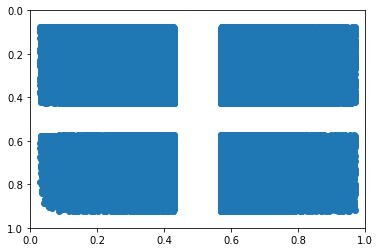

In [23]:
def addAOI(data, aoi_width, aoi_height): 
    aoiCenters = pd.DataFrame(
        [
            [(0.05+0.9*0.2), 0.25],
            [(0.05+0.9*0.8), 0.25],
            [(0.05+0.9*0.2), 0.75],
            [(0.05+0.9*0.8), 0.75]
        ], 
        columns = ['x', 'y'],
        index = ['TL', 'TR', 'BL', 'BR']
    )
    
    data['aoi'] = 0 
    for aoi in aoiCenters.index:
        data.loc[
            (
                (data['x'] > (aoiCenters.loc[aoi, 'x'] - aoi_width/2)) & \
                (data['x'] < (aoiCenters.loc[aoi, 'x'] + aoi_width/2)) & \
                (data['y'] > (aoiCenters.loc[aoi, 'y'] - aoi_height/2)) & \
                (data['y'] < (aoiCenters.loc[aoi, 'y'] + aoi_height/2))
             ), 'aoi'] = aoi
    return data 

data_et_choice = addAOI(data_et_choice, 0.4, 0.35)
data_et_choice['aoi'].unique()

data_plot = data_et_choice.loc[data_et_choice['aoi']!=0, ['x', 'y']]
x = data_plot['x']
y = data_plot['y']
plt.scatter(x, y)
plt.ylim(1, 0)
plt.xlim(0, 1)

In [24]:
def createAOIColumns(data):
    data['aoi_aLL'] = 0
    data['aoi_tLL'] = 0 
    data['aoi_aSS'] = 0 
    data['aoi_tSS'] = 0
    
    # If amounts are on the left side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BR')), 
             'aoi_tSS'] = 1
    
    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_tLL'] = 1
    
    # If amounts are on the right side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BR')),
             'aoi_aSS'] = 1

    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_aLL'] = 1
    return data

data_et_choice = createAOIColumns(data_et_choice)

# Fixations

In [25]:
def fix_counter(aoi_vector):
    aoi_numbers = aoi_vector \
        .replace(['TL', 'TR', 'BL', 'BR'], np.arange(1, 5)) \
        .astype(int) \
        .reset_index(drop=True)
    counter = 0

    fix_counter = np.zeros(len(aoi_numbers))
    fix_counter[0] = int(aoi_numbers[0] != 0)

    for i in np.delete(aoi_numbers.index, 0):
        if (
            (aoi_numbers[i] > 0) &  
            (aoi_numbers[i] != aoi_numbers[i-1])
           ):
            counter += 1

        if aoi_numbers[i] > 0:
            fix_counter[i] = counter 

    return fix_counter

In [26]:
def add_fixation_counter(data):
    data = data.copy()
    data.loc[:, 'fix_counter'] = 0
    
    for subject in tqdm(data['run_id'].unique()):
        for trial in data.loc[data['run_id']==subject, 'withinTaskIndex'].unique():
            
            temp_aoi = data.loc[
                (data['run_id']==subject) &
                (data['withinTaskIndex']==trial), 
                'aoi']
            
            data.loc[
                (data['run_id']==subject) &
                (data['withinTaskIndex']==trial), 
                'fix_counter'] = fix_counter(temp_aoi)

    return data

data_et_choice = add_fixation_counter(data_et_choice)
data_et_choice.groupby(['run_id', 'aoi'])['fix_counter'].count()

100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [04:54<00:00,  1.24s/it]


run_id  aoi
1.0     0       512
        BL       18
        BR       25
        TL        9
        TR       64
               ... 
462.0   0      1486
        BL      158
        BR      449
        TL      375
        TR      231
Name: fix_counter, Length: 1136, dtype: int64

## fixations on trial level

In [27]:
data_trial_choice = data_trial_choice \
    .merge(
        data_et_choice.groupby(['run_id', 'withinTaskIndex'])['fix_counter'].nunique(),
        on=['run_id', 'withinTaskIndex'],
        how='left'
    ) \
    .rename(columns={'n_fixations': 'fix_counter'})

# Eye-Tracking indices

## Add AOI counts

<ipython-input-28-ad184f7a7842>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_choice.groupby(['run_id', 'trial_index']) \


       run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL
0         1.0        145.0        0        2        0        2
1         1.0        148.0        0        1        0        0
2         1.0        151.0        1        0        0        0
3         1.0        154.0        0        1        0        1
4         1.0        157.0        0        0        0        0
...       ...          ...      ...      ...      ...      ...
18715   462.0        380.0        4        0        2        0
18716   462.0        383.0        0        7        0        1
18717   462.0        386.0        0        4        6        0
18718   462.0        389.0        4        0        3        3
18719   462.0        392.0        3        1       17        0

[18720 rows x 6 columns]


(array([6.0961e+04, 1.0048e+04, 2.4690e+03, 8.4900e+02, 2.8500e+02,
        1.4200e+02, 5.8000e+01, 3.2000e+01, 1.0000e+01, 7.0000e+00,
        5.0000e+00, 8.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,   8.9,  17.8,  26.7,  35.6,  44.5,  53.4,  62.3,  71.2,
         80.1,  89. ,  97.9, 106.8, 115.7, 124.6, 133.5, 142.4, 151.3,
        160.2, 169.1, 178. ]),
 <BarContainer object of 20 artists>)

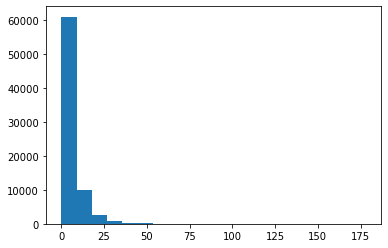

In [28]:
grouped = data_et_choice.groupby(['run_id', 'trial_index']) \
        ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL'].sum() \
        .reset_index() 
print(grouped)

data_plot = pd.DataFrame(pd.concat(
    [
        grouped['aoi_aSS'],
        grouped['aoi_tSS'],
        grouped['aoi_aLL'],
        grouped['aoi_tLL']
    ]), columns=['n']) 

plt.hist(data_plot, bins=20)

In [29]:
for var in ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']:
    if var in data_trial_choice.columns: 
        data_trial_choice = data_trial_choice.drop(columns=[var])
        
data_trial_choice = data_trial_choice.merge(
    grouped, 
    on=['run_id', 'trial_index'], 
    how='left')
    
data_trial_choice.loc[
    :, 
    ['run_id', 'trial_index', 'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']
]

,run_id,trial_index,aoi_aSS,aoi_aLL,aoi_tSS,aoi_tLL
0,1,145,0.0,2.0,0.0,2.0
1,1,148,0.0,1.0,0.0,0.0
2,1,151,1.0,0.0,0.0,0.0
3,1,154,0.0,1.0,0.0,1.0
4,1,157,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
19404,98,496,NaN,NaN,NaN,NaN
19405,98,499,NaN,NaN,NaN,NaN
19406,98,502,NaN,NaN,NaN,NaN
19407,98,505,NaN,NaN,NaN,NaN


##  Option Index

In [30]:
def require_min(data, min_required_count):
    return data.replace(
        np.arange(min_required_count), 
        np.repeat(0, min_required_count)) 

def addOptionIndex(data):
    
    gazePoints_immediate = \
        require_min(data['aoi_aSS'], 3) + \
        require_min(data['aoi_tSS'], 3)
    gazePoints_delay = \
        require_min(data['aoi_aLL'], 3) + \
        require_min(data['aoi_tLL'], 3)
    optionIndex = \
        (gazePoints_immediate - gazePoints_delay) / \
        (gazePoints_immediate + gazePoints_delay)
    
    return optionIndex

data_trial_choice['optionIndex'] = addOptionIndex(data_trial_choice)
print(data_trial_choice['optionIndex'].describe())
print(
    pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['optionIndex']))],
            [sum(data_trial_choice['optionIndex']==1)],
            [sum(data_trial_choice['optionIndex']==0)],
            [sum((data_trial_choice['optionIndex']>0) &
                 (data_trial_choice['optionIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>optionIndex>1', 'total']    
    )
)

print(data_trial_choice.loc[:, ['run_id', 'trial_index', 
                          'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
                          'optionIndex']])
print(data_trial_choice.loc[
    ~data_trial_choice['optionIndex'].isin([-1, 1]) &
    pd.notna(data_trial_choice['optionIndex']), 
    ['run_id', 'trial_index', 
     'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
     'optionIndex']])

count    16398.000000
mean        -0.048058
std          0.825100
min         -1.000000
25%         -1.000000
50%         -0.100000
75%          1.000000
max          1.000000
Name: optionIndex, dtype: float64
                     0
NAN               3011
1                 4765
0                  244
0>optionIndex>1   2843
total            19409
       run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  optionIndex
0           1          145      0.0      2.0      0.0      2.0          NaN
1           1          148      0.0      1.0      0.0      0.0          NaN
2           1          151      1.0      0.0      0.0      0.0          NaN
3           1          154      0.0      1.0      0.0      1.0          NaN
4           1          157      0.0      0.0      0.0      0.0          NaN
...       ...          ...      ...      ...      ...      ...          ...
19404      98          496      NaN      NaN      NaN      NaN          NaN
19405      98          499      NaN      NaN

## Attribute Index

In [31]:
def addAttributeIndex(data):

    gazePoints_amount = \
        require_min(data['aoi_aLL'], 3) + \
        require_min(data['aoi_aSS'], 3)
    gazePoints_time = \
        require_min(data['aoi_tLL'], 3) + \
        require_min(data['aoi_tSS'], 3)

    attributeIndex = \
        (gazePoints_amount - gazePoints_time) / \
        (gazePoints_amount + gazePoints_time)
    
    return attributeIndex


data_trial_choice['attributeIndex'] = addAttributeIndex(data_trial_choice)

print(data_trial_choice['attributeIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['attributeIndex']))],
            [sum(data_trial_choice['attributeIndex']==1)],
            [sum(data_trial_choice['attributeIndex']==0)],
            [sum((data_trial_choice['attributeIndex']>0) &
                 (data_trial_choice['attributeIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>attributeIndex>1', 'total']    
    )
)

print(data_trial_choice.loc[:, ['run_id', 'trial_index', 
                          'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
                          'attributeIndex']])
print(data_trial_choice.loc[
    ~data_trial_choice['attributeIndex'].isin([-1, 1]) &
    pd.notna(data_trial_choice['attributeIndex']), 
    ['run_id', 'trial_index', 
     'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
     'attributeIndex']])

count    16398.000000
mean         0.176558
std          0.719052
min         -1.000000
25%         -0.333333
50%          0.206046
75%          1.000000
max          1.000000
Name: attributeIndex, dtype: float64
                        0
NAN                  3011
1                    5147
0                     435
0>attributeIndex>1   4550
total               19409
       run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  attributeIndex
0           1          145      0.0      2.0      0.0      2.0             NaN
1           1          148      0.0      1.0      0.0      0.0             NaN
2           1          151      1.0      0.0      0.0      0.0             NaN
3           1          154      0.0      1.0      0.0      1.0             NaN
4           1          157      0.0      0.0      0.0      0.0             NaN
...       ...          ...      ...      ...      ...      ...             ...
19404      98          496      NaN      NaN      NaN      NaN             NaN

## Payne Index

### Transitions between AOIs

In [32]:
def et_data_transition_type(data):
    data = data.loc[
        pd.notna(data['aoi']) &
        (data['aoi']!=0), :]
    data['newAOIIndex'] = 0
    data.loc[(data['aoi_aLL']==1), 'newAOIIndex'] = 1
    data.loc[(data['aoi_tLL']==1), 'newAOIIndex'] = 2
    data.loc[(data['aoi_aSS']==1), 'newAOIIndex'] = 4
    data.loc[(data['aoi_tSS']==1), 'newAOIIndex'] = 8
    data.sort_values(by=['run_id', 'withinTaskIndex'])
    # Add a 0 due to the way np.diff works
    data['transition_type'] = np.append([0], np.diff(data['newAOIIndex']))
    data['transition_type'] = abs(data['transition_type']) 

    data.loc[data['t_task']==0, 'transition_type'] = 0

    return data.loc[:, ['run_id', 'trial_index', 't_task', 'transition_type']]

def addTransition_type(data, data_et):
    data_et = et_data_transition_type(data_et)
    data_et.loc[:, 'transition_type'] = data_et.loc[:, 'transition_type']
    
    transition_count = pd.pivot_table(
        data_et.loc[:, ['run_id', 'trial_index', 'transition_type']], 
        index = ['run_id', 'trial_index'],
        columns = ['transition_type'], 
        aggfunc = len,
        fill_value = 0) \
        .reset_index() \
        .rename(columns={
        0: "trans_type_0",
        1: "trans_type_aLLtLL",
        2: "trans_type_tLLaSS",
        3: "trans_type_aLLaSS",
        4: "trans_type_aSStSS",
        6: "trans_type_tLLtSS",
        7: "trans_type_aLLtSS"
    })
    
    transition_columns = ["trans_type_0", "trans_type_aLLtLL", 
            "trans_type_tLLaSS", "trans_type_aLLaSS",
            "trans_type_aSStSS", "trans_type_tLLtSS", 
            "trans_type_aLLtSS"]
    
    for var in transition_columns:
        if var in data: 
            data = data.drop(columns=[var])
        
    data = data.merge(transition_count, on=['run_id', 'trial_index'], how='left') 
    data.loc[:, transition_columns] = data.loc[:, transition_columns] \
        .fillna(0)
    return(data)

data_trial_choice = addTransition_type(data_trial_choice, data_et_choice)
data_trial_choice.loc[
    :, 
    [
        'run_id', 'trial_index',
        'aoi_aLL', 'aoi_aSS', 'aoi_tLL', 'aoi_tSS',
        'trans_type_0', 'trans_type_aLLtLL', 'trans_type_tLLaSS',
        'trans_type_aLLaSS', 'trans_type_aSStSS', 'trans_type_tLLtSS',
        'trans_type_aLLtSS'
    ]
]

<ipython-input-32-9621a8002178>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['newAOIIndex'] = 0
C:\Users\User\miniconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\User\miniconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,run_id,trial_index,aoi_aLL,aoi_aSS,aoi_tLL,aoi_tSS,trans_type_0,trans_type_aLLtLL,trans_type_tLLaSS,trans_type_aLLaSS,trans_type_aSStSS,trans_type_tLLtSS,trans_type_aLLtSS
0,1,145,2.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,148,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,151,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,154,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19404,98,496,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19405,98,499,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19406,98,502,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19407,98,505,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def addPayneIndex(data):
    
    optionWise_transition = \
        data['trans_type_aLLtLL'] + \
        data['trans_type_aSStSS']
    attributeWise_transition = \
        data['trans_type_aLLaSS'] + \
        data['trans_type_tLLtSS']  
        
    payneIndex = \
        (optionWise_transition - attributeWise_transition) / \
        (optionWise_transition + attributeWise_transition) 
    

    return payneIndex

data_trial_choice['payneIndex'] = addPayneIndex(data_trial_choice)

print(data_trial_choice['payneIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['payneIndex']))],
            [sum(data_trial_choice['payneIndex']==1)],
            [sum(data_trial_choice['payneIndex']==0)],
            [sum((data_trial_choice['payneIndex']>0) &
                 (data_trial_choice['payneIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>payneIndex>1', 'total']    
    )
)

data_trial_choice.loc[
    data_trial_choice['fps']>15, 
    ['run_id', 'trial_duration_exact',
     'trans_type_aLLtLL', 'trans_type_aSStSS', 'trans_type_aLLaSS', 'trans_type_tLLtSS',
     'payneIndex'
    ]
]

count    13787.000000
mean         0.183543
std          0.742817
min         -1.000000
25%         -0.333333
50%          0.272727
75%          1.000000
max          1.000000
Name: payneIndex, dtype: float64
                    0
NAN              5622
1                4700
0                2383
0>payneIndex>1   2773
total           19409


,run_id,trial_duration_exact,trans_type_aLLtLL,trans_type_aSStSS,trans_type_aLLaSS,trans_type_tLLtSS,payneIndex
80,103,4929,4.0,2.0,3.0,2.0,0.090909
81,103,7106,7.0,4.0,3.0,1.0,0.466667
82,103,6489,5.0,4.0,3.0,1.0,0.384615
83,103,3878,2.0,2.0,2.0,1.0,0.142857
84,103,2967,2.0,2.0,2.0,0.0,0.333333
...,...,...,...,...,...,...,...
19246,96,1373,1.0,0.0,1.0,0.0,0.000000
19247,96,1232,0.0,0.0,1.0,0.0,-1.000000
19248,96,804,1.0,0.0,1.0,0.0,0.000000
19249,96,1333,1.0,0.0,1.0,1.0,-0.333333


## Aggregate on subject-level

In [34]:
data_subject = merge_by_subject(data_subject, data_trial_choice, 'attributeIndex')
data_subject = merge_by_subject(data_subject, data_trial_choice, 'optionIndex')
data_subject = merge_by_subject(data_subject, data_trial_choice, 'payneIndex')

# k-value

 - Index: Order: A column that stores the order of questions asked
 - aSS: SIR: Column storing the small immediate rewards by choice set
 - aLL: LDR: Column storing the large delayed rewards by choice set
 - tLL: Delay: Column storing the respecitve delays for LDR’s

In [35]:
data_k = data_trial_choice.loc[
    data_trial_choice['run_id']==11, 
    ['run_id', 'withinTaskIndex', 'aSS', 'aLL', 'tLL']]


http://alexanderfengler.github.io/neuroeconomics/K-Estimation/

According to Chabris and Laibson (2008), 'An agent chooses aLL, if Y / (1 + k*t) - X >= 0  holds true'

# Reaction time on subject-level

In [36]:
grouped = data_trial_choice.groupby(['run_id'])['trial_duration_exact'].mean() \
    .reset_index() \
    .rename(columns={'trial_duration_exact': 'choice_rt'})

if 'choice_rt' in data_subject.columns: data_subject = data_subject.drop(columns=['choice_rt'])
data_subject = data_subject.merge(grouped, on='run_id', how='left')
data_subject['choice_rt'].describe()

count     209.000000
mean     2073.046100
std       697.610526
min       567.400000
25%      1627.075000
50%      1984.912500
75%      2420.087500
max      4727.139241
Name: choice_rt, dtype: float64

# Clusters

In [37]:
data_cluster = data_trial_choice.dropna(
    subset=['trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS'] , how='all')

data_cluster.loc[:, [
       'trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS']
                     ].isnull().any()

trans_type_0         False
trans_type_aLLtLL    False
trans_type_tLLaSS    False
trans_type_aLLaSS    False
trans_type_aSStSS    False
trans_type_tLLtSS    False
dtype: bool

In [38]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cluster.loc[
    :, 
    ['trans_type_0',
     'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
     'trans_type_aSStSS', 'trans_type_tLLtSS']
]
                                      )

In [39]:
def clusters(n_clusters):
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(scaled_features)
            
#     https://realpython.com/k-means-clustering-python/
#     print(kmeans.inertia_)
#     print(kmeans.cluster_centers_)
#     print(kmeans.n_iter_)

    return kmeans.labels_

In [40]:
output = []
X = data_cluster[["run_id"]] #, "withinTaskIndex"]]
X_ = sm.add_constant(X)
y = 1-data_cluster[["choseLL"]]  
log_reg = sm.Logit(y, X_).fit() 
output.append([0, log_reg.bic, log_reg.aic])
                  
for n_cluster in range(2, 5):
    data_cluster['cluster' + str(n_cluster)] = clusters(n_cluster)
    X = data_cluster[["run_id", 'cluster' + str(n_cluster)]]
    X_ = sm.add_constant(X)
    y = 1-data_cluster[["choseLL"]]  
    log_reg = sm.Logit(y, X_).fit() 
    output.append([n_cluster, log_reg.bic, log_reg.aic]) 

output = pd.DataFrame(output, columns = ['n_clusters', 'BIC', 'AIC']) \
    .set_index('n_clusters')
output

Optimization terminated successfully.
         Current function value: 0.598365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593640
         Iterations 5


,BIC,AIC
n_clusters,,
0,23247.084561,23231.337576
2,22984.788684,22961.168208
3,23231.285647,23207.665171
4,23073.547286,23049.926809


In [41]:
data_et_choice.columns

Index(['x', 'y', 't', 't_task', 'run_id', 'trial_index', 'withinTaskIndex',
       'amountLeft', 'LL_top', 'look_left', 'look_top', 'aoi', 'aoi_aLL',
       'aoi_tLL', 'aoi_aSS', 'aoi_tSS', 'fix_counter'],
      dtype='object')

# Export data

In [42]:
if not os.path.exists('./data_jupyter/choice_task'):
    os.mkdir('./data_jupyter/choice_task')

data_et_choice.to_csv("data_jupyter/choice_task/data_et_choice.csv", index=False, header=True)
data_trial_choice.to_csv("data_jupyter/choice_task/data_trial_choice.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/choice_task/data_subject_choice.csv", index=False, header=True)

MatLab input

In [43]:
if not os.path.exists('./amasino_dataPrep/data_source'):
    os.mkdir('./amasino_dataPrep/data_source')

data_et_choice.loc[:, 
                       [
                           'run_id', 
                           'withinTaskIndex', 
                           'x', 
                           'y', 
                           't_task'
                       ]
                  ] \
   .to_csv("amasino_dataPrep/data_source/schneegansEtAl_ET.csv", index=False, header=False)

In [44]:
data_trial_choice.loc[:, 
                       [
                           'run_id', 
                           'withinTaskIndex', 
                           'optionIndex', 
                           'attributeIndex', 
                           'payneIndex'
                       ]
                  ] \
    .fillna(0) \
    .to_csv("amasino_dataPrep/intermediateCSVs/ET_indices.csv", index=False, header=False)

In [45]:
# Subject ID, Amount smaller sooner (SS), Amount larger later (LL), Time SS, Time LL, 
# choice, response time, side, response side, condition.
data_trial_choice.loc[:, 
                          [
                              'run_id', 
                              'aSS', 
                              'aLL', 
                              'tSS', 
                              'tLL', 
                              'choseLL', 
                              'trial_duration_exact', 
                              'LL_top',
                              'choseTop'
                          ]
                     ] \
    .to_csv("amasino_dataPrep/data_source/schneegansEtAl_behavior.csv", index=False, header=False)

data_trial_choice.loc[:,
                          [
                              'run_id', 
                              'aSS', 
                              'aLL', 
                              'tSS', 
                              'tLL', 
                              'choseLL', 
                              'trial_duration_exact', 
                              'LL_top',
                              'choseTop'
                          ]
                     ] \
    .to_csv("fitK/fit_k_input.csv", index=False, header=True)

In [46]:
data_subject.loc[:, ['run_id', 'choseLL']] \
    .to_csv("amasino_dataPrep/intermediateCSVs/percLeft.csv", index=False, header=False)

# Feedback

In [47]:
print('Success! Script ran through')

Success! Script ran through
